In [1]:
import xarray as xr
import pandas as pd
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import matplotlib.pyplot as plt
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [8]:
simus = ['control', 'AMOCoff_m1', 'AMOCoff_m2', 'AMOCoff_m3', 'AMOCoff_m4', 'AMOCoff_m5']

In [9]:
with xr.open_dataset('prepend_0yrs/amoc_tas_control.nc') as ds:
    ds = ds.load()

# Extract the first x years 
n_years = 50
n_months = 12 * n_years
ds_prepend = ds.isel(time=slice(0, n_months))

for s in simus:
    ds_sel = xr.open_dataset(f'prepend_0yrs/amoc_tas_{s}.nc')
    
    # Concatenate along the time dimension
    ds_extended = xr.concat([ds_prepend, ds_sel], dim='time') 

    # Generate new time range
    new_time = pd.date_range(start='2000-01-01', periods=1200 + n_months, freq='MS')
    ds_extended['time'] = ('time', new_time)
    
    ds_extended.to_netcdf(f'prepend_{n_years}yrs/amoc_tas_{n_years}yr_{s}.nc')

In [10]:
with xr.open_dataset('prepend_0yrs/amoc_pr_control.nc') as ds:
    ds = ds.load()

ds_prepend = ds.isel(time=slice(0, n_months))

for s in simus:
    ds_sel = xr.open_dataset(f'prepend_0yrs/amoc_pr_{s}.nc')
    
    # Concatenate along the time dimension
    ds_extended = xr.concat([ds_prepend, ds_sel], dim='time') 

    # Generate new time range
    new_time = pd.date_range(start='2000-01-01', periods=1200 + n_months, freq='MS')
    ds_extended['time'] = ('time', new_time)
    
    ds_extended.to_netcdf(f'prepend_{n_years}yrs/amoc_pr_{n_years}yr_{s}.nc')

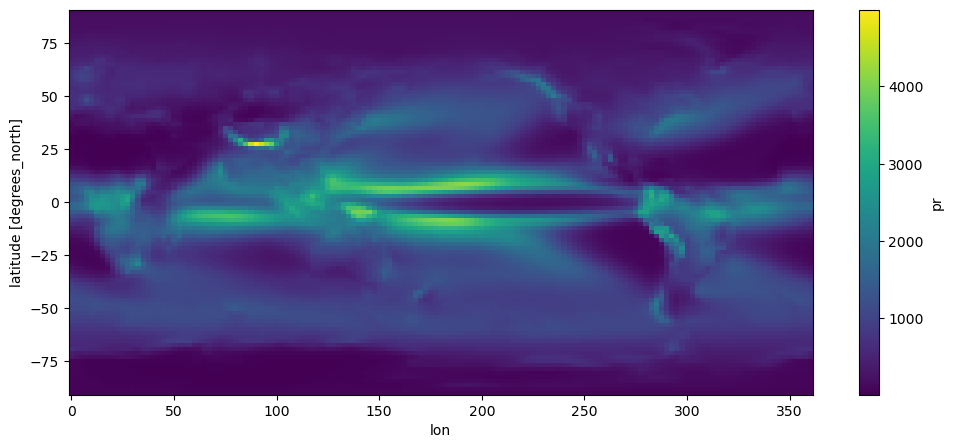

In [7]:
(ds_extended.pr.mean(dim='time') * 365 * 24 * 60 * 60).plot();

In [45]:
with xr.open_dataset('SurfaceTemperature.nc') as ds:
    ds = ds.load()
ds.simulation

<xarray.DataArray 'simulation' (simulation: 6)> Size: 240B
array(['control', 'AMOCoff_m1', 'AMOCoff_m2', 'AMOCoff_m3', 'AMOCoff_m4',
       'AMOCoff_m5'], dtype='<U10')
Coordinates:
  * simulation  (simulation) <U10 240B 'control' 'AMOCoff_m1' ... 'AMOCoff_m5'

In [4]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL
from oggm.shop import gcm_climate

In [5]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')  # print less log messages than the default 

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_gcm_run', reset=True)

# RGI glaciers: Ngojumba and Khumbu
rgi_ids = ['RGI60-15.03473', 'RGI60-15.03733']

# Go - get the pre-processed glacier directories
# You have to explicitly indicate the url from where you want to start from
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=DEFAULT_BASE_URL)

2025-06-06 10:42:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-06 10:42:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-06 10:42:51: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-06-06 10:42:53: oggm.workflow: init_glacier_directories from prepro level 5 on 2 glaciers.
2025-06-06 10:42:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


In [40]:
# Download the files
ft = 'amoc_tas_control.nc'
fp = 'amoc_pr_control.nc'
rid = '_control'
# bias correct them
workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                             filesuffix=rid,  # recognize the climate file for later
                             fpath_temp=ft,  # temperature projections
                             fpath_precip=fp,  # precip projections
                             year_range=('2000', '2019'),
                             );

2025-06-06 14:03:55: oggm.workflow: Execute entity tasks [process_cmip_data] on 2 glaciers


In [41]:
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, ys=2000, 
                             climate_filename='gcm_data',  # use gcm_data, not climate_historical
                             climate_input_filesuffix=rid,  # use the chosen scenario
                             init_model_filesuffix='_spinup_historical',
                             init_model_yr=2000,
                             output_filesuffix=rid,  # recognize the run for later
                            );

2025-06-06 14:05:06: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2 glaciers


2025-06-06 14:05:14: oggm.utils: Applying global task compile_run_output on 2 glaciers
2025-06-06 14:05:14: oggm.utils: Applying compile_run_output on 2 gdirs.


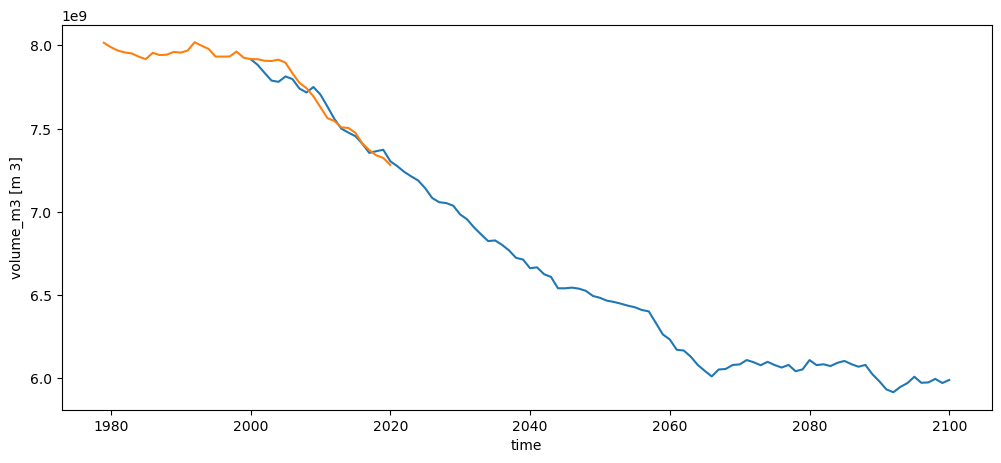

In [43]:
ds = utils.compile_run_output(gdirs, input_filesuffix=rid)

with xr.open_dataset(gd.get_filepath('model_diagnostics', filesuffix='_spinup_historical')) as dsr:
    dsr = dsr.load()

ds.sel(rgi_id='RGI60-15.03473').volume.plot();
dsr.volume_m3.plot()

In [34]:
dsr

<xarray.Dataset> Size: 4kB
Dimensions:                   (time: 42)
Coordinates:
  * time                      (time) float64 336B 1.979e+03 ... 2.02e+03
    calendar_year             (time) int64 336B 1979 1980 1981 ... 2019 2020
    calendar_month            (time) int64 336B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    hydro_year                (time) int64 336B 1979 1980 1981 ... 2019 2020
    hydro_month               (time) int64 336B 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4
Data variables:
    volume_m3                 (time) float64 336B 8.016e+09 ... 7.282e+09
    volume_bsl_m3             (time) float64 336B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl_m3             (time) float64 336B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_m2                   (time) float64 336B 6.153e+07 ... 6.09e+07
    area_m2_min_h             (time) float64 336B 6.148e+07 ... 6.09e+07
    length_m                  (time) float64 336B 2.094e+04 ... 2.094e+04
    calving_m3                (time) float64 336B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    calving_rate_myr          (time) float64 336B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    is_fixed_geometry_spinup  (time) bool 42B False False False ... False False
Attributes:
    description:          OGGM model output
    oggm_version:         1.6.1.dev26+gf8a1745
    calendar:             365-day no leap
    creation_date:        2023-08-15 16:59:57
    water_level:          0
    glen_a:               1.6353579444236134e-23
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  nh

In [37]:
gd

<oggm.GlacierDirectory>
  RGI id: RGI60-15.03473
  Region: 15: South Asia East
  Subregion: 15-02: E Himalaya                      
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 61.054 km2
  Lon, Lat: (86.715911865, 28.089468002)
  Grid (nx, ny): (247, 322)
  Grid (dx, dy): (119.0, -119.0)

In [15]:
with xr.open_dataset(gd.get_filepath('gcm_data', filesuffix=rid)) as dsc:
    dsc = dsc.load()

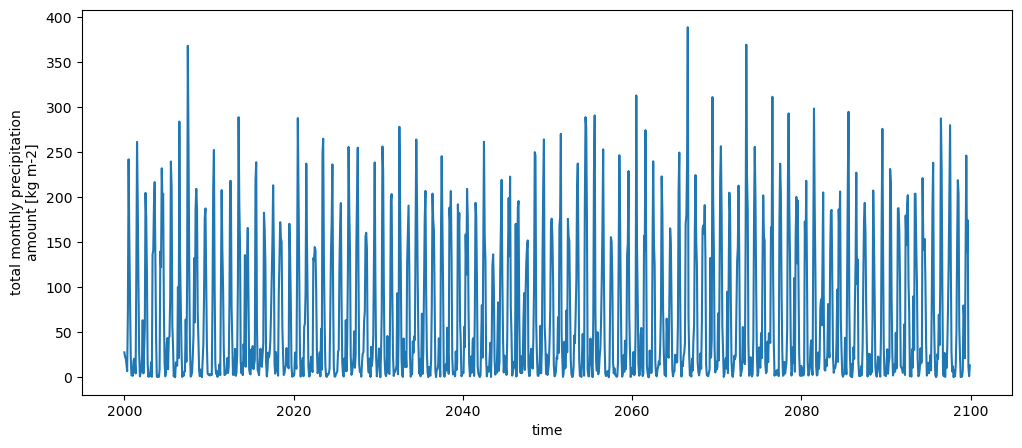

In [18]:
dsc.prcp.plot();

In [46]:
with xr.open_dataset('amoc_tas_control.nc') as ds:
    ds = ds.load()

with xr.open_dataset('amoc_tas_AMOCoff_m1.nc') as dsa:
    dsa = dsa.load()

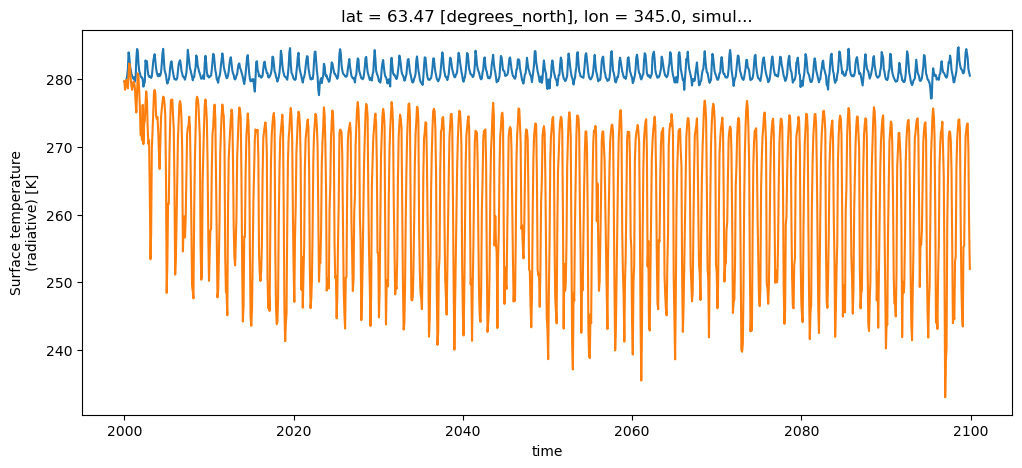

In [51]:
ds.tas.sel(lon=-16+360, lat=64, method='nearest').plot();
dsa.tas.sel(lon=-16+360, lat=64, method='nearest').plot();

In [ ]:
ctrl = ds.isel(simulation=0).TS
ens1 = ds.isel(s§imulation=1).TS

In [ ]:
ctrl

In [ ]:
avg_ctrl = ctrl.isel(time=slice(-300, -1)).mean(dim='time')
avg_ens1 = ens1.isel(time=slice(-300, -1)).mean(dim='time')

In [ ]:
(avg_ens1 - avg_ctrl).plot();

In [ ]:
ax = plt.axes(projection=ccrs.Robinson())
(avg_ens1 - avg_ctrl).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines();

In [ ]:
iceland = (avg_ens1 - avg_ctrl).sel(longitude=slice())

In [ ]:
avg_ens1.lon